In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np

# Task 1

In [2]:
# load the data set
def get_data():
    # Normalize the data between [-1, 1] so that it can be convergent easily 
    data_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=data_tf, download=True)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader

def to_img(x):
    x = (x + 1.) * 0.5
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28, 128),
                          nn.ReLU(True),
                          nn.Linear(128, 64),
                          nn.ReLU(True),
                          nn.Linear(64, 12),
                          nn.ReLU(True),
                          nn.Linear(12, 3)
                        )
        self.decoder = nn.Sequential(nn.Linear(3, 12),
                          nn.ReLU(True),
                          nn.Linear(12, 64),
                          nn.ReLU(True),
                          nn.Linear(64, 128),
                          nn.ReLU(True),
                          nn.Linear(128, 28*28),
                          nn.Tanh()
                        )
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [3]:
# Configuration of hyperparameters
batch_size = 128
lr = 1e-2
weight_decay = 1e-5
epoches = 20

model = autoencoder()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Use up GPUs
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs")
  model = nn.DataParallel(model)

In [4]:
input_list = []
output_list = []
i = 15

In [6]:
train_data = get_data()
criterion = nn.MSELoss()
optimizier = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if torch.cuda.is_available():
    model.cuda()
    print("using GPU")

for epoch in range(epoches):
    if epoch in [epoches * 0.25, epoches * 0.5]:
        for param_group in optimizier.param_groups:
            param_group['lr'] *= 0.1
    temp_1 = None
    temp_2 = None
    for img, _ in train_data:
        img = img.view(img.size(0), -1)
        img = img.to(device)

        temp_1 = img

        # forward        
        _, output = model(img)
        loss = criterion(output, img)

        temp_2 = output
        
        # backward
        optimizier.zero_grad()
        loss.backward()
        optimizier.step()

    print("epoch=", epoch, loss.data.float())

    if(i <= 20):
      input_list.append(temp_1)
      output_list.append(temp_2)
      i += 1

    for param_group in optimizier.param_groups:
        print(param_group['lr'])

    if (epoch+1) % 5 == 0:
        print("epoch: {}, loss is {}".format((epoch+1), loss.data))
        pic = to_img(output.cpu().data)
        if not os.path.exists('./simple_autoencoder'):
            os.mkdir('./simple_autoencoder')
        save_image(pic, './simple_autoencoder/image_{}.png'.format(epoch + 1))

using GPU
epoch= 0 tensor(0.1431, device='cuda:0')
0.01
epoch= 1 tensor(0.1390, device='cuda:0')
0.01
epoch= 2 tensor(0.1413, device='cuda:0')
0.01
epoch= 3 tensor(0.1413, device='cuda:0')
0.01
epoch= 4 tensor(0.1438, device='cuda:0')
0.01
epoch: 5, loss is 0.1438438594341278
epoch= 5 tensor(0.1228, device='cuda:0')
0.001
epoch= 6 tensor(0.1350, device='cuda:0')
0.001
epoch= 7 tensor(0.1232, device='cuda:0')
0.001
epoch= 8 tensor(0.1275, device='cuda:0')
0.001
epoch= 9 tensor(0.1283, device='cuda:0')
0.001
epoch: 10, loss is 0.12831085920333862
epoch= 10 tensor(0.1250, device='cuda:0')
0.0001
epoch= 11 tensor(0.1245, device='cuda:0')
0.0001
epoch= 12 tensor(0.1316, device='cuda:0')
0.0001
epoch= 13 tensor(0.1235, device='cuda:0')
0.0001
epoch= 14 tensor(0.1208, device='cuda:0')
0.0001
epoch: 15, loss is 0.12082014232873917
epoch= 15 tensor(0.1191, device='cuda:0')
0.0001
epoch= 16 tensor(0.1340, device='cuda:0')
0.0001
epoch= 17 tensor(0.1288, device='cuda:0')
0.0001
epoch= 18 tensor(0

In [ ]:
def show_digit(v):
  code = Variable(torch.FloatTensor([v]).cuda())
  decode = model.decoder(code)
  decode_img = to_img(decode).squeeze()
  decode_img = decode_img.data.cpu().numpy() * 255
  plt.imshow(decode_img.astype('uint8'), cmap='gray')
  plt.show()

In [16]:
# len(input_list)
# input_list[0].size()

len(output_list)
output_list[0].size()

torch.Size([128, 784])

In [24]:
input = input_list[:5]
output = output_list[:5]

print(input[0].size())

for i in range(5):
  input[i] = input[i].cpu().detach().numpy().reshape([128,28,28])
  output[i] = output[i].data.cpu().reshape([128,28,28])

torch.Size([128, 784])


(28, 28)


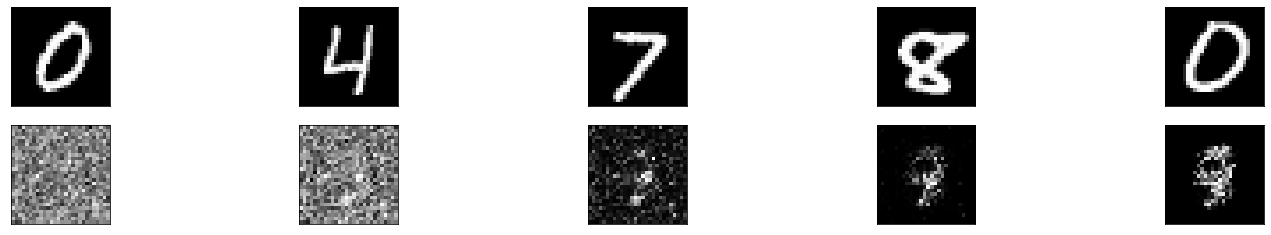

<Figure size 432x288 with 0 Axes>

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,4))

plt.figure()
print(input[i][0].shape)

for images, row in zip([input, output], axes):
  for img, ax in zip(images, row):
    ax.imshow(img[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [27]:
# Read out the decoded images by reconstruction path
def show_image(reconsPath):
  Image = mpimg.imread(reconsPath)
  plt.imshow(Image) 
  plt.axis('off') 
  plt.show()

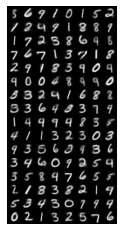

In [29]:
reconsPath = './simple_autoencoder/image_10.png'
show_image(reconsPath)

# Task 2
## Variational Autoencoder
1) Implement a VAE(30%)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [32]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

In [33]:
dataset = torchvision.datasets.MNIST(root='../../../data/minist',
                      train=True,
                      transform=transforms.ToTensor(),
                      download=True
                    )

data_loader = torch.utils.data.DataLoader(dataset=dataset,
                        batch_size=batch_size, 
                        shuffle=True)

Extracting ../../../data/minist/MNIST/raw/train-images-idx3-ubyte.gz to ../../../data/minist/MNIST/raw


Extracting ../../../data/minist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../../data/minist/MNIST/raw




Extracting ../../../data/minist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../../data/minist/MNIST/raw


Extracting ../../../data/minist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../../data/minist/MNIST/raw
Processing...
Done!


In [43]:
# VAE model
class VAE(nn.Module):
  def __init__(self, image_size=784, h_dim=400, z_dim=20):
      super(VAE, self).__init__()
      self.fc1 = nn.Linear(image_size, h_dim)
      self.fc2 = nn.Linear(h_dim, z_dim) 
      self.fc3 = nn.Linear(h_dim, z_dim) 
      self.fc4 = nn.Linear(z_dim, h_dim)
      self.fc5 = nn.Linear(h_dim, image_size)
      
  def encode(self, x):
      h = F.relu(self.fc1(x))
      return self.fc2(h), self.fc3(h)
  
  def reparameterize(self, mu, log_var):
      std = torch.exp(log_var/2)
      eps = torch.randn_like(std)
      return mu + eps * std

  def decode(self, z):
      h = F.relu(self.fc4(z))
      return F.sigmoid(self.fc5(h))
  
  # encode -> decode
  def forward(self, x):
      mu, log_var = self.encode(x)
      z = self.reparameterize(mu, log_var)
      x_reconst = self.decode(z)
      return x_reconst, mu, log_var


In [44]:
model2 = VAE().to(device)

In [45]:
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [50]:
counter = 0
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Get samples and forward 
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model2(x)
        
        # Conpute the reconstruction loss and KL div
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # back propagation
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # randomly generate images
        z = torch.randn(batch_size, z_dim).to(device)
        
        out = model2.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        if counter == 0:
          temp_in = z 
          temp_out = out

        # reconstructed images
        out, _, _ = model2(x)

        # set the dimension = 3
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=2)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [100/469], Reconst Loss: 10260.4463, KL Div: 3216.1079
Epoch[1/15], Step [200/469], Reconst Loss: 10183.5469, KL Div: 3248.0093
Epoch[1/15], Step [300/469], Reconst Loss: 9963.1875, KL Div: 3252.3743
Epoch[1/15], Step [400/469], Reconst Loss: 9718.8672, KL Div: 3232.8677
Epoch[2/15], Step [100/469], Reconst Loss: 9901.6445, KL Div: 3269.0347
Epoch[2/15], Step [200/469], Reconst Loss: 9818.0537, KL Div: 3144.8909
Epoch[2/15], Step [300/469], Reconst Loss: 10412.1738, KL Div: 3186.6802
Epoch[2/15], Step [400/469], Reconst Loss: 10706.5332, KL Div: 3273.3027
Epoch[3/15], Step [100/469], Reconst Loss: 10094.3496, KL Div: 3355.4585
Epoch[3/15], Step [200/469], Reconst Loss: 10353.2051, KL Div: 3392.3052
Epoch[3/15], Step [300/469], Reconst Loss: 9956.9180, KL Div: 3246.3469
Epoch[3/15], Step [400/469], Reconst Loss: 9950.7686, KL Div: 3281.8840
Epoch[4/15], Step [100/469], Reconst Loss: 9708.5186, KL Div: 3218.2878
Epoch[4/15], Step [200/469], Reconst Loss: 10043.2715, KL 

## a) Plot digits(30%)

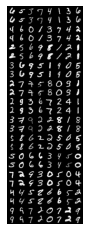

In [48]:
reconsPath = './samples/reconst-15.png'
show_image(reconsPath)

## b) Plot the variance vector of the decoder for a single input as image(25%)

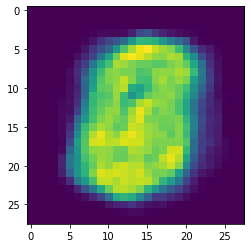

In [68]:
# print(temp_in)
# print(temp_out)

variance = np.var(temp_out.cpu().detach().numpy(),axis=0)
plt.imshow(variance[0])